Name: Tian Liu  
UIN: 525004380

### Explanation

Here in this project, I implemented Transformer Encoder to extract features from input texts, and formulate the problem of predicting next word as a multi-class classification problem by adding few dense layers after the TransformerEncoder.

To test the pretrained model (by grader), please refer to the last section `Reload the Final Model for Testing`.

In [1]:
!nvidia-smi

Tue May  3 00:45:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling/'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling


### Load Train Data

In [5]:
import pickle
import numpy as np

train_input = pickle.load(open('DS_5_train_input_prefixList', 'rb'))
train_output = pickle.load(open('DS_5_train_input_nextWord', 'rb'))

In [13]:
# examine the train data

for i in range(3):
  print(train_input[i])
  print('->')
  print(train_output[i])
  print()

['a', 'g', 'b', 'f', 'a', 'f', 'a', 'e', 'a', 'k', 'a', 'j', 'c', 'f', 'b', 'f', 'c', 'd', 'a', 'k']
->
a

['a', 'k', 'a', 'e', 'a', 'e', 'a', 'e', 'a', 'i', 'a', 'f', 'b', 'e', 'a', 'i', 'c', 'd', 'b', 'g']
->
c

['a', 'k', 'c', 'f', 'a', 'd', 'a', 'g', 'b', 'e', 'a', 'h', 'c', 'd', 'a', 'h', 'a', 'k', 'a']
->
k



In [14]:
# check the data and vocab size in given training data
max_len = 0
max_ct = 0
for text in train_input:
  max_ct = max(max_ct, len(text))
  for word in text:
    max_len = max(max_len, len(word))

print('max_len', max_len)
print('max_ct', max_ct)

max_len = 0
max_ct = 0
for text in train_output:
  max_ct = max(max_ct, len(text))
  for word in text:
    max_len = max(max_len, len(word))

print('max_len', max_len)
print('max_ct', max_ct)

max_len 1
max_ct 48
max_len 1
max_ct 1


In [15]:
# prepare train_texts by concatenate prefix and nextWord

train_texts = []
for i in range(len(train_input)):
# for i in range(10):
  prefix = train_input[i]
  nextword = train_output[i]
  sen = ' '.join(train_input[i]) + ' ' + train_output[i]
  train_texts.append(sen)

  # print('prefix', prefix)
  # print('nextword', nextword)
  # print('sen',sen)
  # print("-----")

In [136]:
# save the train_texts out for rebuilding the text_vec for testing by grader
pickle.dump(train_texts, open('final_model/train_texts','wb')) 

### Prepare TextVectorization Layer

In [16]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 66 # max len in train input of project is 64
vocab_size = 13 # since only 13 unique letters in train_input
text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_vectorization.adapt(train_texts)

print(len(text_vectorization.get_vocabulary()))

13


### Split Data into Train and Val Sets

In [17]:
# split into train and val

import random

random.shuffle(train_texts)
num_val_samples = int(0.15 * len(train_texts))
num_train_samples = len(train_texts) - num_val_samples

train_set = train_texts[:num_train_samples]
val_set = train_texts[num_train_samples:]

print(len(train_set))
print(len(val_set))

4250
750


In [18]:
# prepare the input and output for the multiclass classification dataset

def to_one_hot(labels, dimension=13):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# get the index token dicts
index_token = dict(enumerate(text_vectorization.get_vocabulary()))

tokens_index = dict()
for idx, tok in index_token.items():
  tokens_index[tok] = idx

print(index_token)
print(tokens_index)
print(len(tokens_index))

trainset_prefix = [sen[:-2] for sen in train_set]
trainset_nextWord = [sen[-1:] for sen in train_set]
valset_prefix = [sen[:-2] for sen in val_set]
valset_nextWord = [sen[-1:] for sen in val_set]

# print(trainset_prefix)
# print(trainset_nextWord)

X_train = text_vectorization(trainset_prefix)
y_train = [tokens_index[nextWord] for nextWord in trainset_nextWord]
y_train = to_one_hot(y_train, len(tokens_index))
# print('y_train', y_train)

X_val = text_vectorization(valset_prefix)
y_val = [tokens_index[nextWord] for nextWord in valset_nextWord]
y_val = to_one_hot(y_val, len(tokens_index))

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

{0: '', 1: '[UNK]', 2: 'a', 3: 'b', 4: 'c', 5: 'e', 6: 'd', 7: 'f', 8: 'g', 9: 'k', 10: 'i', 11: 'j', 12: 'h'}
{'': 0, '[UNK]': 1, 'a': 2, 'b': 3, 'c': 4, 'e': 5, 'd': 6, 'f': 7, 'g': 8, 'k': 9, 'i': 10, 'j': 11, 'h': 12}
13
(4250, 66)
(4250, 13)
(750, 66)
(750, 13)


### Transformer Encoder for Multi-class Classification

#### Positional Embedding and Transformer Encoder

In [80]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#### End-to-end Model for Multi-class Classification

In [95]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 128
latent_dim = 512
num_heads = 8

output_size = 13

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) # reduce sequence to a single vector
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None)]            0         
                                                                 
 positional_embedding_16 (Po  (None, None, 128)        10112     
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_16 (Tra  (None, None, 128)        659712    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                          

#### Train the Model

In [96]:
# tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

class predNextAcc(keras.callbacks.Callback):
    def __init__(self,
                 prefix,
                 nextWord,
                #  model_input_length,
                #  temperatures=(1.,),
                #  print_freq=1
                 ):
        self.prefix = text_vectorization(prefix)
        self.nextWord = nextWord
        # self.model_input_length = model_input_length
        # self.temperatures = temperatures
        # self.print_freq = print_freq
        

    def on_epoch_end(self, epoch, logs=None):
        tokenized_sentences = self.prefix
        predictions = self.model(tokenized_sentences)
        pred_next = predictions[:, 0, :]
        print('\npred_next.shape', pred_next.shape)
        next_tokens = np.argmax(pred_next, axis=1) # check axis=1 here
        print('next_tokens.shape', next_tokens.shape)

        pred_nextWords = [tokens_index[i] for i in next_tokens]

        # target_tokens = text_vectorization(self.nextWord)
        # print('target_tokens.shape', target_tokens.shape)

        target_words = self.nextWord
        wordAcc = 0
        match_ct = 0
        total_ct = len(target_words)
        for i in range(total_ct):
          if pred_nextWords[i] == target_words[i]:
            match_ct += 1
        print('match_ct =', match_ct)
        print('total_ct =', total_ct)
        print('wordAcc =', match_ct / total_ct)

        # for temperature in self.temperatures:
        #     print("== Generating with temperature", temperature)
        #     sentence = self.prompt
        #     for i in range(self.generate_length):
        #         tokenized_sentence = text_vectorization([sentence])
        #         predictions = self.model(tokenized_sentence)
        #         next_token = sample_next(predictions[0, i, :])
        #         sampled_token = tokens_index[next_token]
        #         sentence += " " + sampled_token
        #     print(sentence)

# prefix = [sen.strip()[:-2] for sen in train_set[:300]]
# nextWord = [sen.strip()[-1] for sen in train_set[:300]]

# prefix = [sen.strip()[:-2] for sen in train_texts[:1000]]
# nextWord = [sen.strip()[-1] for sen in train_texts[:1000]]

# prefix = [sen.strip()[:-2] for sen in val_set]
# nextWord = [sen.strip()[-1] for sen in val_set]

# print(prefix)
# print(nextWord)
# stop

# predNextAcc_callback = predNextAcc(prefix, nextWord)

# print(X_train.shape)
# print(y_train.shape)

# history = model.fit(X_train, y_train, batch_size=64, shuffle=True, validation_data=(X_val, y_val), epochs=20, callbacks=[predNextAcc_callback])

history = model.fit(X_train, y_train, batch_size=64, shuffle=True, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
67/67 [==============================] - 4s 30ms/step - loss: 2.8617 - accuracy: 0.1504 - val_loss: 2.3236 - val_accuracy: 0.1147
Epoch 2/30
67/67 [==============================] - 2s 23ms/step - loss: 2.3951 - accuracy: 0.1586 - val_loss: 2.1602 - val_accuracy: 0.1787
Epoch 3/30
67/67 [==============================] - 1s 22ms/step - loss: 2.2347 - accuracy: 0.1809 - val_loss: 2.0703 - val_accuracy: 0.2440
Epoch 4/30
67/67 [==============================] - 1s 18ms/step - loss: 2.1398 - accuracy: 0.2054 - val_loss: 2.0161 - val_accuracy: 0.1947
Epoch 5/30
67/67 [==============================] - 1s 18ms/step - loss: 2.0495 - accuracy: 0.2445 - val_loss: 1.8281 - val_accuracy: 0.3120
Epoch 6/30
67/67 [==============================] - 1s 19ms/step - loss: 1.9439 - accuracy: 0.2685 - val_loss: 1.7813 - val_accuracy: 0.2573
Epoch 7/30
67/67 [==============================] - 1s 18ms/step - loss: 1.9192 - accuracy: 0.2718 - val_loss: 1.5895 - val_accuracy: 0.3347
Epoch 8/30
67

#### Save the trained model

In [99]:
model.save('tianliu_525004380_project3_transformer_trained_valacc0.3507.model')
model.save_weights('tianliu_525004380_project3_transformer_trained_valacc0.3507.weights') # save by weights
model.save('tianliu_525004380_project3_transformer_trained_valacc0.3507.model.h5') # save by h5 format

INFO:tensorflow:Assets written to: tianliu_525004380_project3_transformer_trained_valacc0.3507.model/assets


INFO:tensorflow:Assets written to: tianliu_525004380_project3_transformer_trained_valacc0.3507.model/assets


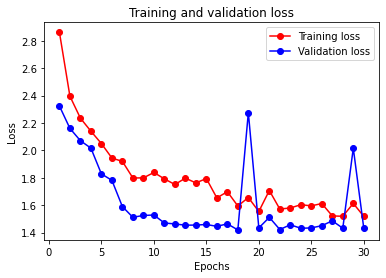

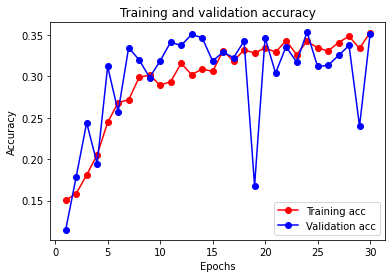

In [100]:
# plot training and validation loss and acc

import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", marker="o", label="Training loss")
plt.plot(epochs, val_loss_values, "b", marker="o",label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", marker="o", label="Training acc")
plt.plot(epochs, val_acc, "b", marker="o", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Retrain on the entire given training data

In [19]:
trainset_prefix_all = [sen[:-2] for sen in train_texts]
trainset_nextWord_all = [sen[-1:] for sen in train_texts]

X_train = text_vectorization(trainset_prefix_all)
y_train = [tokens_index[nextWord] for nextWord in trainset_nextWord_all]
y_train = to_one_hot(y_train, len(tokens_index))

print(X_train.shape)
print(y_train.shape)

(5000, 66)
(5000, 13)


In [115]:
# rebuild model

embed_dim = 128
latent_dim = 512
num_heads = 8

output_size = 13

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) # reduce sequence to a single vector
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, None)]            0         
                                                                 
 positional_embedding_19 (Po  (None, None, 128)        10112     
 sitionalEmbedding)                                              
                                                                 
 transformer_encoder_19 (Tra  (None, None, 128)        659712    
 nsformerEncoder)                                                
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                          

In [116]:
# retrain model on entire training data
history = model.fit(X_train, y_train, batch_size=64, shuffle=True, epochs=30)

Epoch 1/30
79/79 [==============================] - 4s 17ms/step - loss: 2.7399 - accuracy: 0.1534
Epoch 2/30
79/79 [==============================] - 1s 16ms/step - loss: 2.2864 - accuracy: 0.1740
Epoch 3/30
79/79 [==============================] - 1s 16ms/step - loss: 2.1807 - accuracy: 0.1942
Epoch 4/30
79/79 [==============================] - 1s 16ms/step - loss: 2.0471 - accuracy: 0.2368
Epoch 5/30
79/79 [==============================] - 1s 16ms/step - loss: 1.9657 - accuracy: 0.2552
Epoch 6/30
79/79 [==============================] - 1s 16ms/step - loss: 1.8634 - accuracy: 0.2790
Epoch 7/30
79/79 [==============================] - 1s 16ms/step - loss: 1.8119 - accuracy: 0.2946
Epoch 8/30
79/79 [==============================] - 1s 16ms/step - loss: 1.8343 - accuracy: 0.2852
Epoch 9/30
79/79 [==============================] - 1s 16ms/step - loss: 1.7991 - accuracy: 0.2972
Epoch 10/30
79/79 [==============================] - 1s 16ms/step - loss: 1.7533 - accuracy: 0.3020
Epoch 11/

### Save Final Trained Model

In [117]:
# model.save('final_model/tianliu_525004380_project3_transformer_final.model')
model.save_weights('final_model/tianliu_525004380_project3_transformer_final.weights') # save by weights
# model.save('final_model/tianliu_525004380_project3_transformer_final.model.h5') # save by h5 format

INFO:tensorflow:Assets written to: final_model/tianliu_525004380_project3_transformer_final.model/assets


INFO:tensorflow:Assets written to: final_model/tianliu_525004380_project3_transformer_final.model/assets


### Reload the Final Model for Testing

In [8]:
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling/'

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling/'
/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project3_LanguageModeling


#### Load final model and double check

Here we have to load by weights to ensure the correctness of the model

In [118]:
# load trained model # NOTICE the following load_model will not yield the same accuracy as loading by weights, reasons to be explored

# final_model = keras.models.load_model('final_model/tianliu_525004380_project3_transformer_final.model', custom_objects={"PositionalEmbedding": PositionalEmbedding, "TransformerEncoder": TransformerEncoder})


In [9]:
# rebuild model by loading weights
import tensorflow as tf
from tensorflow import keras
from keras import layers

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions # add up the word embedding and position embedding

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config



embed_dim = 128
latent_dim = 512
num_heads = 8
sequence_length = 66
vocab_size = 13
output_size = 13

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x) # reduce sequence to a single vector
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_size, activation="softmax")(x)

final_model = keras.Model(inputs, outputs)
# model.summary()

final_model.load_weights('final_model/tianliu_525004380_project3_transformer_final.model')

final_model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [20]:
# test on the val dataset again to verify the correctness of the loaded model

# res = final_model.evaluate(X_val, y_val)
# res = final_model.evaluate(X_train, y_train)

157/157 [==============================] - 2s 6ms/step - loss: 1.4456 - accuracy: 0.3626


#### Get Predictions on Testing Data

In [11]:
import pickle

# For grader to load the test file here
test_prefix = pickle.load(open('DS_5_test_input_prefixList', 'rb')) 
test_nextWord = pickle.load(open('DS_5_test_input_nextWord', 'rb'))

# for self-testing code
# test_prefix = train_input 
# test_nextWord = train_output

# rebuild the text_vectorization by loading train_texts
train_texts = pickle.load(open('final_model/train_texts', 'rb'))

from tensorflow.keras.layers import TextVectorization

sequence_length = 66 # max len in train input of project is 64
vocab_size = 13 # since only 13 unique letters in train_input
text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

text_vectorization.adapt(train_texts)
print(len(text_vectorization.get_vocabulary()))

# rebuild the index_token
index_token = dict(enumerate(text_vectorization.get_vocabulary()))

print(index_token)

def predict_next_word(test_prefix):
  
  # preprocess the test input
  test_texts = [' '.join(test_words) for test_words in test_prefix]
  X_test = text_vectorization(test_texts)
  
  y_pred = final_model.predict(X_test)
  # print('y_pred.shape =', y_pred.shape)
  nextWord_pred = np.argmax(y_pred, axis=1)
  # print('nextWord_pred.shape =', nextWord_pred.shape)

  # decode idx back to word
  res = []
  for idx in nextWord_pred:
    res.append(index_token[idx])

  return res

# get predictions
test_nextWord_pred = predict_next_word(test_prefix) 

# calculate word accuracy
total_ct = len(test_nextWord)
match_ct = 0
for i in range(total_ct):
  if test_nextWord[i] == test_nextWord_pred[i]:
    match_ct += 1

print("testing word accuracy =", match_ct / total_ct)


13
{0: '', 1: '[UNK]', 2: 'a', 3: 'b', 4: 'c', 5: 'e', 6: 'd', 7: 'f', 8: 'g', 9: 'k', 10: 'i', 11: 'j', 12: 'h'}
testing word accuracy = 0.3626
